In [1]:
import numpy as np
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from matplotlib.colors import TwoSlopeNorm

In [2]:
# Constants
L = 2.5                       # side length of the source cube
M, N = 866, 866               # number of boundary and source points
p = np.array([0., 1., 0.])    # polarisation vector
d = np.array([0., 0., -1.])  # propagation direction (orthogonal to p)
k = 2 * np.pi                 # wavenumber
res = 50                      # resolution per face for evaluation

def E(x):
  """
  E(x) = p e^{ik d \dot x}, d orthogonal to p
    x: array-like, shape (..., 3)
    Returns an array of shape (..., 3)
  """
  return p * np.exp(1j * k * x @ d)[:, None]  # (3,) * (M, 1) -> (M, 3)

def fs(x, y):
  """
  G(x, y) = (I + ∇∇/k²) G₀(x, y), where G₀(r) = e^(ikr)/4πr
    x: boundary point(s), shape (M, 3)
    y: source point(s), shape (N, 3)
    Returns an array of shape (M, N, 3, 3)
  """
  d = x[:, None] - y[None]  # (M, N, 3)
  r = np.linalg.norm(d, axis=2, keepdims=True)  # (M, N, 1)
  kr = k * r
  kr2 = kr ** 2
  fI = (1 + 1j / kr - 1 / kr2) * np.exp(1j * kr) / r  # (M, N, 1, 1)
  fR = (1 + 3j / kr - 3 / kr2) * np.exp(1j * kr) / r  # (M, N, 1, 1)
  I = np.eye(3)[None, None, :, :]  # (1, 1, 3, 3)
  rhat = d / r  # (M, N, 3)
  return (I * fI[..., None] -
         (rhat[..., None] * rhat[..., None, :]) * fR[..., None])  # (M, N, 3, 3)

In [3]:
class Cube:
  def __init__(self, half_side=0.5):
    self.half_side = half_side

  def generate_points(self, M):
    # Generate unique points covering the cube surface based on M
    m = int(np.ceil(np.sqrt(M / 6)))
    grid = np.linspace(-self.half_side, self.half_side, m)
    U, V = np.meshgrid(grid, grid)
    U_flat = U.flatten()
    V_flat = V.flatten()
    pts_list = []
    for face in ['x+', 'x-', 'y+', 'y-', 'z+', 'z-']:
      if face == 'x+':
        pts = np.column_stack((np.full(U_flat.shape, self.half_side), U_flat, V_flat))
      elif face == 'x-':
        pts = np.column_stack((np.full(U_flat.shape, -self.half_side), U_flat, V_flat))
      elif face == 'y+':
        pts = np.column_stack((U_flat, np.full(U_flat.shape, self.half_side), V_flat))
      elif face == 'y-':
        pts = np.column_stack((U_flat, np.full(U_flat.shape, -self.half_side), V_flat))
      elif face == 'z+':
        pts = np.column_stack((U_flat, V_flat, np.full(U_flat.shape, self.half_side)))
      elif face == 'z-':
        pts = np.column_stack((U_flat, V_flat, np.full(U_flat.shape, -self.half_side)))
      pts_list.append(pts)
    all_pts = np.concatenate(pts_list, axis=0)
    unique_pts = np.unique(all_pts, axis=0)
    return unique_pts

  def get_face_points(self, face, res):
    # Create evaluation grid points for a given face of the cube
    grid_lin = np.linspace(-self.half_side, self.half_side, res)
    U, V = np.meshgrid(grid_lin, grid_lin)
    if face == 'x+':
      X, Y, Z = np.full_like(U, self.half_side), U, V
    elif face == 'x-':
      X, Y, Z = np.full_like(U, -self.half_side), U, V
    elif face == 'y+':
      X, Y, Z = U, np.full_like(U, self.half_side), V
    elif face == 'y-':
      X, Y, Z = U, np.full_like(U, -self.half_side), V
    elif face == 'z+':
      X, Y, Z = U, V, np.full_like(U, self.half_side)
    elif face == 'z-':
      X, Y, Z = U, V, np.full_like(U, -self.half_side)
    pts = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
    return X, Y, Z, pts

  @staticmethod
  def draw_unit_cube(ax, half_side=0.5):
    # Draw the wireframe of a cube with given half_side on the provided Axes3D
    corners = np.array([[-half_side, -half_side, -half_side],
                        [-half_side, -half_side,  half_side],
                        [-half_side,  half_side, -half_side],
                        [-half_side,  half_side,  half_side],
                        [ half_side, -half_side, -half_side],
                        [ half_side, -half_side,  half_side],
                        [ half_side,  half_side, -half_side],
                        [ half_side,  half_side,  half_side]])
    edges = [(0,1), (0,2), (0,4), (1,3), (1,5),
             (2,3), (2,6), (3,7), (4,5), (4,6), (5,7), (6,7)]
    for i, j in edges:
      ax.plot([corners[i,0], corners[j,0]],
              [corners[i,1], corners[j,1]],
              [corners[i,2], corners[j,2]], color='blue', linewidth=0.8)

  def filter_visible_points(self, points, view_vec, tol=1e-8):
    # Return only the points on faces that are visible from the view direction
    visible = []
    hs = self.half_side
    for pt in points:
      normals = []
      if np.isclose(pt[0], hs, atol=tol):
        normals.append(np.array([1, 0, 0]))
      if np.isclose(pt[0], -hs, atol=tol):
        normals.append(np.array([-1, 0, 0]))
      if np.isclose(pt[1], hs, atol=tol):
        normals.append(np.array([0, 1, 0]))
      if np.isclose(pt[1], -hs, atol=tol):
        normals.append(np.array([0, -1, 0]))
      if np.isclose(pt[2], hs, atol=tol):
        normals.append(np.array([0, 0, 1]))
      if np.isclose(pt[2], -hs, atol=tol):
        normals.append(np.array([0, 0, -1]))
      if any(np.dot(n, view_vec) > 0 for n in normals):
        visible.append(pt)
    return np.array(visible)

  def plot_views(self, points, viewpoints):
    # Plot cube surface points from different viewpoints and draw the unit cube
    n_views = len(viewpoints)
    fig, axarr = plt.subplots(1, n_views, subplot_kw={'projection': '3d'},
                                figsize=(5 * n_views, 5))
    if n_views == 1:
      axarr = [axarr]
    for ax, (elev, azim) in zip(axarr, viewpoints):
      elev_rad, azim_rad = np.radians(elev), np.radians(azim)
      view_vec = np.array([np.cos(elev_rad)*np.cos(azim_rad),
                           np.cos(elev_rad)*np.sin(azim_rad),
                           np.sin(elev_rad)])
      visible_pts = self.filter_visible_points(points, view_vec)
      ax.scatter(visible_pts[:,0], visible_pts[:,1], visible_pts[:,2],
                 s=8, c='red', alpha=0.8, depthshade=False)
      Cube.draw_unit_cube(ax, half_side=0.5)
      ax.set_title(f"View: elev={elev}°, azim={azim}°", fontsize=12)
      ax.view_init(elev, azim)
      ax.set_xlim([-self.half_side*2, self.half_side*2])
      ax.set_ylim([-self.half_side*2, self.half_side*2])
      ax.set_zlim([-self.half_side*2, self.half_side*2])
      ax.set_box_aspect([1, 1, 1])
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_zticks([])
    plt.show()

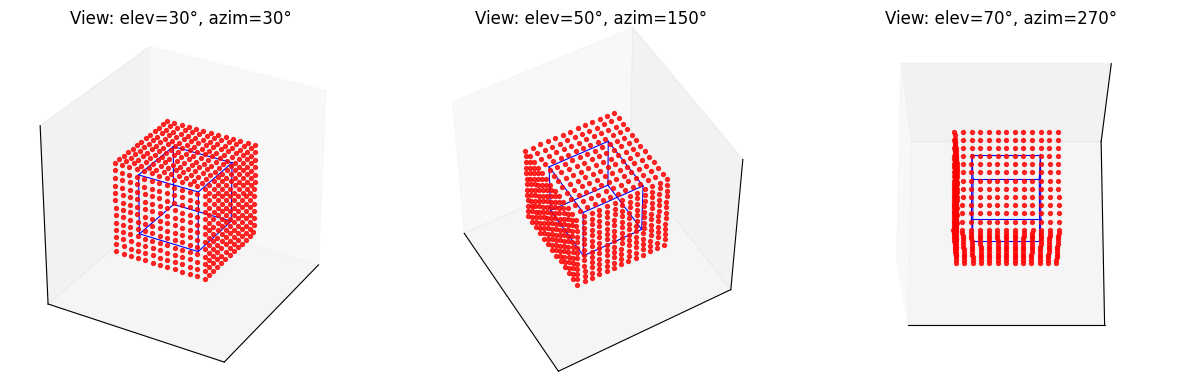

In [4]:
# Plot views of parametrisation
N_outer = 1000
outer_scale = 1.5
outer_cube = Cube(half_side=outer_scale/2)
pts_outer = outer_cube.generate_points(N_outer)
viewpoints = [(30, 30), (50, 150), (70, 270)]
outer_cube.plot_views(pts_outer, viewpoints)

In [5]:
# Source points
source_cube = Cube(half_side=L/2)
y = source_cube.generate_points(N)  # (N, 3)

# Boundary points
unit_cube = Cube(half_side=0.5)
x = unit_cube.generate_points(M)  # (M, 3)

# Form matrix A
A = fs(x, y)  # (M, N, 3, 3)
A = A.transpose(0, 2, 1, 3)  # (M, 3, N, 3)
A = A.reshape(3 * M, 3 * N)  # (3M, 3N)

# Form vector b
b = E(x)  # (M, 3)
b = b.reshape(3 * M)  # (3M,)

# Solve lstsq for coefficients
alpha, _, _, _ = lstsq(A, b)  # (3N,)
alpha = alpha.reshape(N, 3)  # (N, 3)

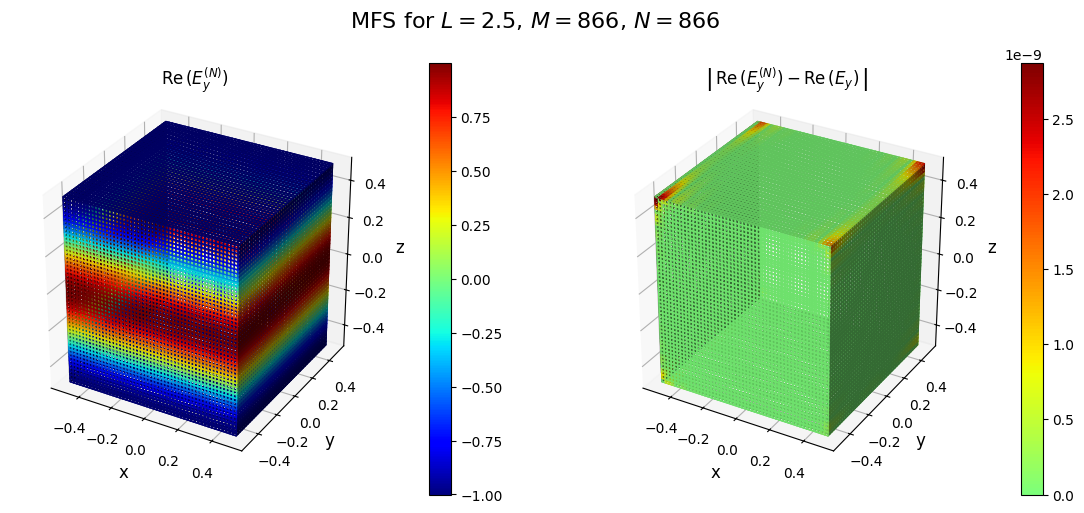

In [6]:
# Compute approximation and error on each face
faces = ['x+', 'x-', 'y+', 'y-', 'z+', 'z-']
eval_faces = []
for face in faces:
  X, Y, Z, pts = unit_cube.get_face_points(face, res)
  u = np.sum(fs(pts, y) @ alpha[:, :, None], axis=1)[..., 0]
  f = np.real(u[:, 1]).reshape(res, res)
  f_exact = np.real(E(pts)[:, 1]).reshape(res, res)
  err = np.abs(f - f_exact)
  eval_faces.append((X, Y, Z, f, err))

# Accumulate results and set up colorbars
f = np.concatenate([fa.flatten() for (_, _, _, fa, _) in eval_faces])
norm1 = colors.Normalize(vmin=f.min(), vmax=f.max())
f_err = np.concatenate([fe.flatten() for (_, _, _, _, fe) in eval_faces])
norm2 = colors.Normalize(vmin=0, vmax=f_err.max())
jet_half = colors.LinearSegmentedColormap.from_list('jet_half',
              plt.cm.jet(np.linspace(0.5, 1, 256)))

# Prepare figure
fig = plt.figure(figsize=(14, 7))
fig.suptitle(r"MFS for $L=" + f"{L}" + r"$, $M=" + f"{M}" + r"$, $N=" + f"{N}" + r"$", fontsize=16, y=0.88)
ax1 = fig.add_subplot(121, projection='3d')

# Plot MFS approximation
for X, Y, Z, fa, _ in eval_faces:
  ax1.plot_surface(X, Y, Z, facecolors=plt.cm.jet(norm1(fa)),
                   rstride=1, cstride=1, antialiased=True, alpha=0.01)
ax1.set_title(r"$\mathrm{Re}\,(E^{(N)}_y)$", fontsize=12)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_zlabel('z', fontsize=12)
ax1.set_box_aspect([1, 1, 1])
mappable1 = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm1)
mappable1.set_array(f)
plt.colorbar(mappable1, aspect=20, ax=ax1, pad=0.1, shrink=0.8)

# Plot error from exact solution
ax2 = fig.add_subplot(122, projection='3d')
for X, Y, Z, _, err in eval_faces:
  ax2.plot_surface(X, Y, Z, facecolors=jet_half(norm2(err)),
                   rstride=1, cstride=1, antialiased=True, alpha=0.01)
ax2.set_title(r"$\left|\, \mathrm{Re}\,(E^{(N)}_y) - \mathrm{Re}\,(E_y) \,\right|$", fontsize=12)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_zlabel('z', fontsize=12)
ax2.set_box_aspect([1, 1, 1])
mappable2 = plt.cm.ScalarMappable(cmap=jet_half, norm=norm2)
mappable2.set_array(f_err)
plt.colorbar(mappable2, aspect=20, ax=ax2, pad=0.1, shrink=0.8)
plt.show()

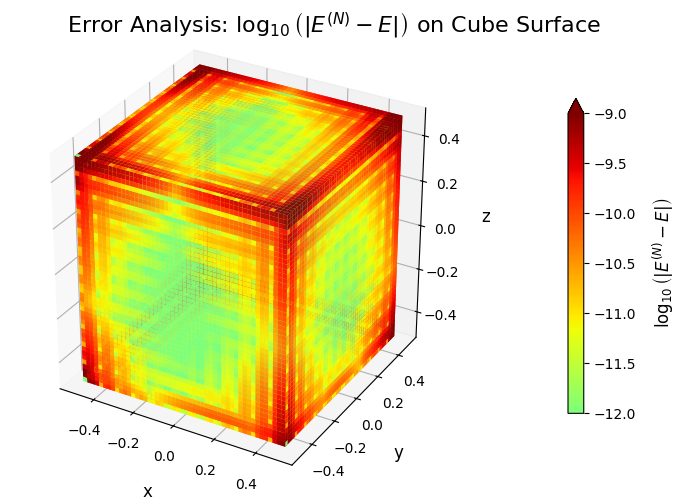

In [7]:
# Evaluate on each face (log error)
epsilon = 1e-16
eval_faces_log = []
for face in faces:
  X, Y, Z, pts = unit_cube.get_face_points(face, res)
  u = np.sum(fs(pts, y) @ alpha[:, :, None], axis=1)[..., 0]
  f = np.real(u[:, 1]).reshape(res, res)
  err_norm = np.linalg.norm(u - E(pts), axis=1).reshape(res, res)
  log_err = np.log10(err_norm + epsilon)
  eval_faces_log.append((X, Y, Z, f, log_err))

# Accumulate and create colorbar ranging from 10^-12 to 10^-9
log_err = np.concatenate([le.flatten() for (_, _, _, _, le) in eval_faces_log])
norm_custom = colors.Normalize(vmin=-12, vmax=-9)

# Plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
for X, Y, Z, _, log_err_face in eval_faces_log:
  facecolors = jet_half(norm_custom(log_err_face))
  ax.plot_surface(X, Y, Z, facecolors=facecolors,
                  rstride=1, cstride=1, antialiased=True,
                  linewidth=0, shade=False, alpha=0.95)
ax.set_xlabel('x', fontsize=12, labelpad=10)
ax.set_ylabel('y', fontsize=12, labelpad=10)
ax.set_zlabel('z', fontsize=12, labelpad=10)
ax.set_box_aspect([1, 1, 1])
mappable = plt.cm.ScalarMappable(cmap=jet_half, norm=norm_custom)
mappable.set_array(log_err)
cbar = plt.colorbar(mappable, ax=ax, pad=0.1, shrink=0.7, extend='max')
cbar.set_label(r'$\log_{10}\left(|E^{(N)}-E|\right)$', fontsize=12, labelpad=10)
cbar.ax.tick_params(labelsize=10)
plt.subplots_adjust(top=0.85, bottom=0.1, left=0.05, right=0.95)
plt.suptitle(r"Error Analysis: $\log_{10}\left(|E^{(N)}-E|\right)$ on Cube Surface",
             fontsize=16, x=0.62, y=0.86, ha='center', va='center')
plt.show()

<ipython-input-8-d71e419ba937>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.93])


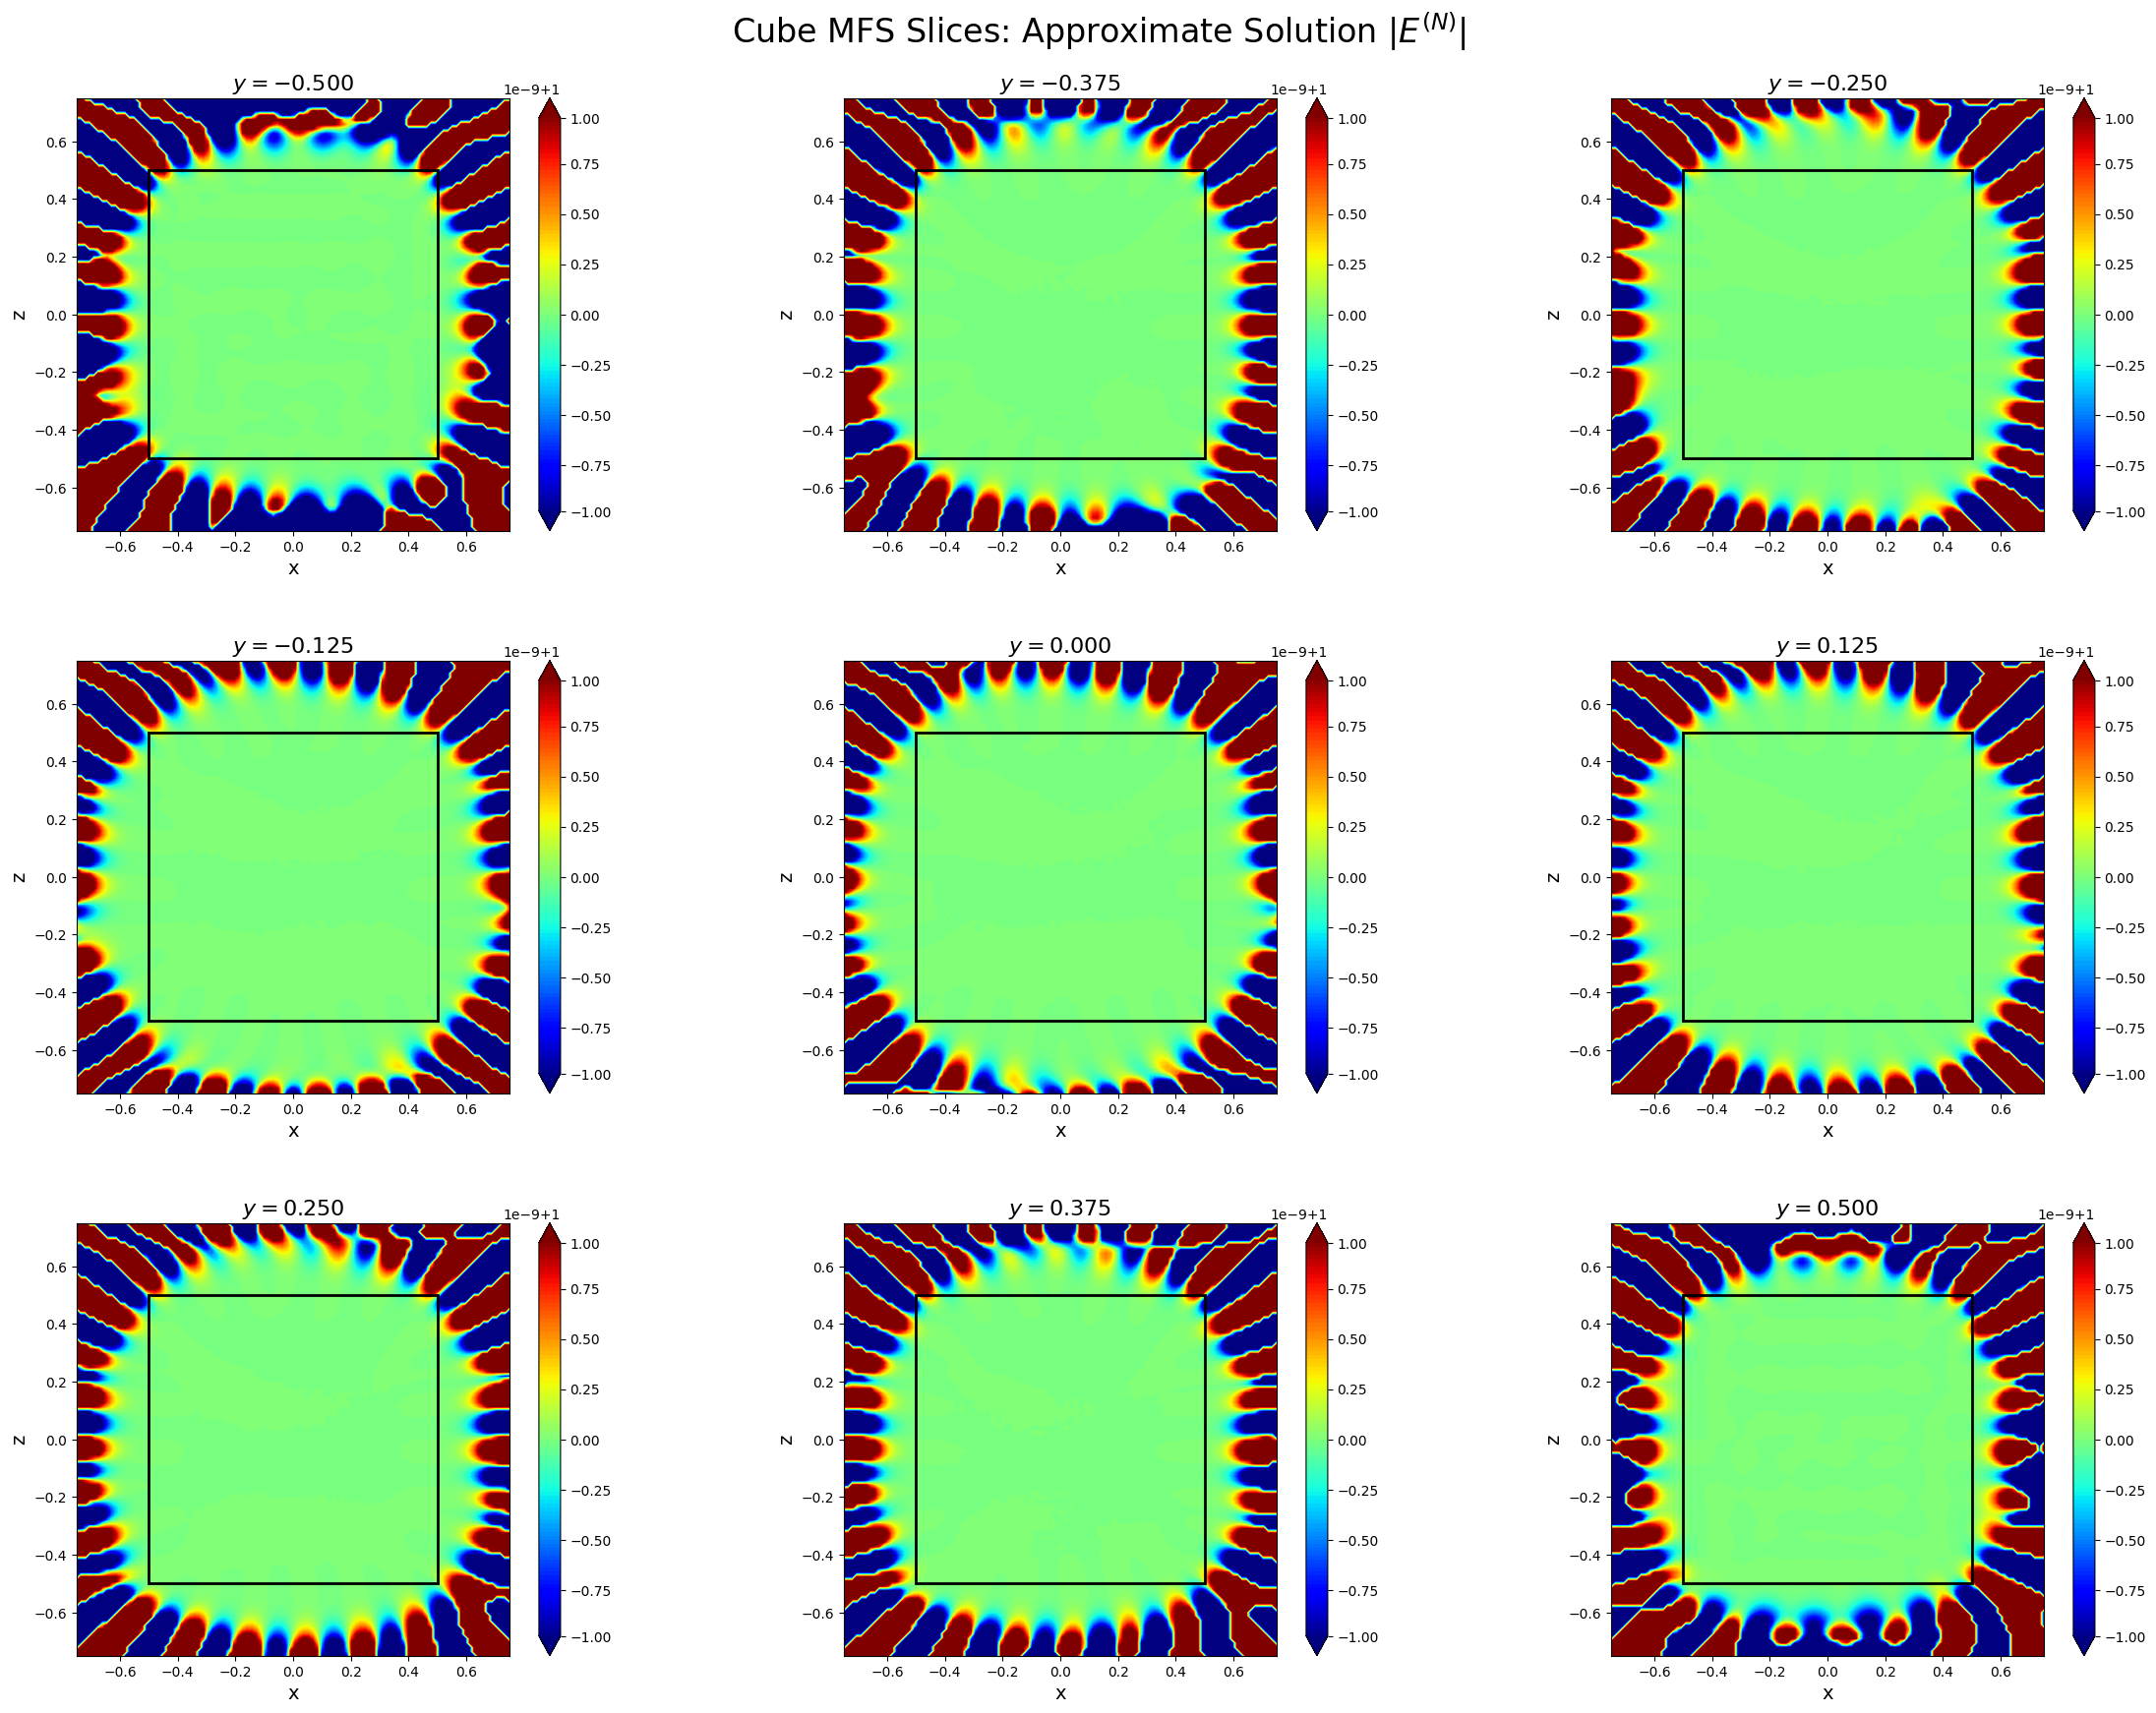

In [8]:
# Contour plot options
opts = {"levels": 100, "cmap": "jet", "extend": "both"}

# Define the y–slice locations
y_slices = np.linspace(-0.5, 0.5, 9)

# Set up a testing grid in the x–z plane
n_grid, x_min, x_max = 100, -0.75, 0.75
grid = np.linspace(x_min, x_max, n_grid)
X, Z = np.meshgrid(grid, grid)

# Choose a common normalisation for all contour plots
vmin, vmax = 1 - 1e-9, 1 + 1e-9
global_norm = TwoSlopeNorm(vmin=vmin, vcenter=1, vmax=vmax)

# Prepare the figure and grid layout
fig = plt.figure(figsize=(24, 18))
outer_gs = GridSpec(3, 3, left=0.05, right=0.95, top=0.93, bottom=0.05,
                    wspace=0.3, hspace=0.3)

for i, y_slice in enumerate(y_slices):
  ax = fig.add_subplot(outer_gs[i])

  # Build and flatten the evaluation points for the current slice
  pts = np.dstack((X, np.full(X.shape, y_slice), Z)).reshape(-1, 3)

  # Evaluate the approximate solution at these points
  u_approx = np.sum(fs(pts, y) @ alpha[..., None], axis=1)[..., 0]

  # Evaluate the magnitude of the computed solution
  sol = np.linalg.norm(u_approx, axis=1).reshape(X.shape)

  # Clip the solution values to be within [vmin, vmax]
  sol_clipped = np.clip(sol, vmin, vmax)

  # Create the contour plot using the shared normalisation
  cs = ax.contourf(X, Z, sol_clipped, norm=global_norm, **opts)

  # Add an outline square representing the unit cube's face (side length 1)
  ax.add_patch(plt.Rectangle((-0.5, -0.5), 1.0, 1.0,
                         fill=False, edgecolor='black', lw=2, zorder=10))

  # Set axis properties and labels
  ax.set_aspect('equal', 'box')
  ax.set_xlabel("x", fontsize=14)
  ax.set_ylabel("z", fontsize=14, labelpad=4)
  ax.set_title(f"$y = {y_slice:.3f}$", fontsize=16)
  ax.set_xlim(x_min, x_max)
  ax.set_ylim(x_min, x_max)

  # Add an individual colorbar for this subplot
  ticks = np.linspace(vmin, vmax, 9)
  fig.colorbar(cs, ax=ax, pad=0.05, ticks=ticks)

plt.suptitle("Cube MFS Slices: Approximate Solution $|E^{(N)}|$", fontsize=24, y=0.98)
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.93])
plt.show()